# Server-side for updating the base_model.
In this jupyter notebook, we simulate how the server updates the base model.  
The server retrieves encrypted weights from both users User A and User B. The weights are added together and decrypted. The new weights are averaged and used to update the Dense layer weights.

#### Import Libraries

In [135]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import tenseal as ts


## Creating server dataset. 
The server dataset consists of all digits from 0 to 9 from the MNIST dataset. The dataset is split into 3 main parts: Server data, User A data and User B data.  
In this section, the server dataset contains the first 20,000 MNIST images and correspoding labels.

In [136]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [137]:
# Slicing the MNIST original dataset to retain only part of the dataset.
x_train = x_train[:20000,:,:]
y_train = y_train[:20000]
x_test = x_test[:4000,:,:]
y_test  = y_test[:4000]

In [138]:
# Length of the new dataset
print("x_train:",len(x_train))
print("y_train:",len(y_train))
print("x_test:",len(x_test))
print("y_test:",len(y_test))

x_train: 20000
y_train: 20000
x_test: 4000
y_test: 4000


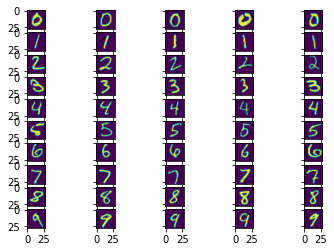

In [139]:
# Display a sample of the server dataset. 
digits = {}
for i in range(10):
    digits[i] = np.where(y_test==i)[0][:5]
#print(digits)

fig, ax = plt.subplots(10, 5, sharex='col', sharey='row')
for i in range(10):
    for j in range(5):
        ax[i, j].imshow(x_test[digits[i][j]])

## CKKS Encryption Scheme
In this section, we load the weights, deserialize the weights, decrypt and apply the averaging for the CKKS encryption scheme.

In [140]:
start_time = time.time()

# load : get the context key
key_query_file = open('key_query', "rb")
context_key = pickle.load(key_query_file)
key_query_file.close()

# recreate the key.
context = ts.context_from(context_key["context"])

In [141]:
# load : get the data from file
bob_weights_file = open('bob_enc', "rb")
bob_weights = pickle.load(bob_weights_file)
bob_weights_file.close()

In [142]:
# Recreating the CKKS encrypted tensors from their serialized counterparts.
#context = ts.context_from(bob_weights["context"])
enc_x1 = ts.ckks_tensor_from(context, bob_weights["data1"])
enc_x2 = ts.ckks_tensor_from(context, bob_weights["data2"])

In [143]:
# Decrypting the 2 encrypted arrays to form the original weight array.
# This is done since protobuf is limited up to 2GB, and the encrpyted array is ~ 2.5GB.
denc_x1 = enc_x1.decrypt().tolist()
denc_x2 = enc_x2.decrypt().tolist()

In [144]:
# Since the encrypyted array was splitted to cater for the 2GB limit, we restore the array to their original shape.
denc_x = np.dstack((denc_x1, denc_x2))

In [145]:
# load : get the data from file
alice_weights_file = open('alice_enc', "rb")
alice_weights = pickle.load(alice_weights_file)
alice_weights_file.close()

In [146]:
# Recreating the CKKS encrypted tensors from their serialized counterparts.
#context = ts.context_from(alice_weights["context"])
enc_y1 = ts.ckks_tensor_from(context, alice_weights["data1"])
enc_y2 = ts.ckks_tensor_from(context, alice_weights["data2"])

In [147]:
# Decrypting the 2 encrypted arrays to form the original weight array.
# This is done since protobuf is limited up to 2GB, and the encrpyted array is ~ 2.5GB.
denc_y1 = enc_y1.decrypt().tolist()
denc_y2 = enc_y2.decrypt().tolist()

In [148]:
# Since the encrypyted array was splitted to cater for the 2GB limit, we restore the array to their original shape.
denc_y = np.dstack((denc_y1, denc_y2))

In [149]:
# Addition of User A weights to that of User B's.
# The masking vector is cancelled out after addition.
result = (denc_x + denc_y)

In [150]:
# Averaging the weights
result_avg = result / 2
print("--- %s seconds ---" % (time.time() - start_time))


--- 91.81345176696777 seconds ---


In [151]:
# For FHE addition, we can add the encrypted weights together from the two users 
# and obtain nearly the same result.
result_1 = enc_x1 + enc_y1
result_2 = enc_x2 + enc_y2

# Then, we decrypt the result and stack it together since we had to split the original weights
# to cater for the protobuf 2GB limit.
result_1_dec = result_1.decrypt().tolist()
result_2_dec = result_2.decrypt().tolist()
result_dec = np.dstack((result_1_dec, result_1_dec))

# Averaging the weights
result_dec_avg = result_dec / 2

### Loading the base_model

In [152]:
## Model's architecture.
# model_base = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform')
# ])

# model_base.summary()

In [153]:
# Loading the base_model.
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7840      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                100       
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


### Updating the base_model weights for Dense layer.

## Loading updated model.
In this section, we uload the updated model which have the averaged weights from the server.

In [154]:
# Replacing the weights with updated weights.
new_model.layers[1].set_weights(result_avg)

In [155]:
# Compiling the model.
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [156]:
# Training the updated_model.
new_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100


e:\UDM\M2_privacyinAI\code_final\venv\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


157/157 [==============================] - 1s 3ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.7841 - val_loss: 0.5546 - val_sparse_categorical_accuracy: 0.8505
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.5312 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.5117 - val_sparse_categorical_accuracy: 0.8655
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.5006 - sparse_categorical_accuracy: 0.8238 - val_loss: 0.4997 - val_sparse_categorical_accuracy: 0.8692
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.4860 - sparse_categorical_accuracy: 0.8270 - val_loss: 0.4780 - val_sparse_categorical_accuracy: 0.8723
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.4698 - sparse_categorical_accuracy: 0.8328 - val_loss: 0.4663 - val_sparse_categorical_accuracy: 0.8750
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.4633 - sparse_categorical_accu

In [157]:
# Saving the updated_model
new_model.save('saved_model/updated_model')

INFO:tensorflow:Assets written to: saved_model/updated_model\assets


### Predictions on the base_model

7


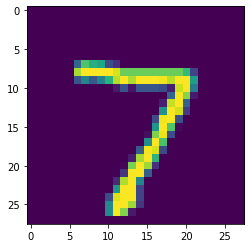

In [158]:
predictions = new_model.predict(x_test)
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])
plt.show()

### Accuracy of the base_model

In [159]:
# Creating a multiclass confusion matrix before training.
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion
print("--- %s seconds ---" % (time.time() - start_time))

--- 162.85454487800598 seconds ---


## Gentry's Encryption Scheme
In this section, we load the weights, deserialize the weights, decrypt and apply the averaging for the Gentry's encryption scheme.

In [160]:
start_time = time.time()
# Initial Parameters
r = 3
p = 29
q = 22

In [161]:
# load : get the data from file
bob_weights_file = open('bob_enc_gentry', "rb")
bob_weights_dict = pickle.load(bob_weights_file)
bob_weights_file.close()

# Load Bob's weights
bob_weights = bob_weights_dict["data1"]

In [162]:
# load : get the data from file
alice_weights_file = open('Alice_enc_gentry', "rb")
alice_weights_dict = pickle.load(alice_weights_file)
alice_weights_file.close()

# Load Alice's weights
alice_weights = alice_weights_dict["data1"]

In [163]:
# Adding both encrypted mask w/ weights.
total = np.add(bob_weights, alice_weights)

total_decrypt = [((z % p) % 2) for z in total]

# Check shape of weights first.
for x in total_decrypt:
    for y in range(784):
        for z in range(10):
            #print(total_decrypt[0][y][z])
            if total_decrypt[0][y][z] > 1:
                total_decrypt[0][y][z] = total_decrypt[0][y][z] - 2


#print("--- %s seconds ---" % (time.time() - start_time))


In [164]:
# Average the weights.
total_decrypt = np.divide(total_decrypt, 2)

### Loading the base_model

In [165]:
## Model's architecture.
# model_base = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform')
# ])

# model_base.summary()

In [166]:
# Loading the base_model.
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7840      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                100       
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


### Updating the base_model weights for Dense layer.

In [167]:
# Replacing the weights with updated weights.
new_model.layers[1].set_weights(total_decrypt)

In [168]:
# Compiling the model.
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [169]:
# Training the updated_model.
new_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100
  1/157 [..............................] - ETA: 29s - loss: 8.2570 - sparse_categorical_accuracy: 0.3281

e:\UDM\M2_privacyinAI\code_final\venv\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


157/157 [==============================] - 1s 3ms/step - loss: 2.0705 - sparse_categorical_accuracy: 0.5454 - val_loss: 0.9839 - val_sparse_categorical_accuracy: 0.6827
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.9736 - sparse_categorical_accuracy: 0.6673 - val_loss: 0.7709 - val_sparse_categorical_accuracy: 0.7555
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.8191 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.6759 - val_sparse_categorical_accuracy: 0.7945
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.7437 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.6168 - val_sparse_categorical_accuracy: 0.8130
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.7056 - sparse_categorical_accuracy: 0.7621 - val_loss: 0.5690 - val_sparse_categorical_accuracy: 0.8270
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6748 - sparse_categorical_accu

In [170]:
# Saving the updated_model
new_model.save('saved_model/updated_model')

INFO:tensorflow:Assets written to: saved_model/updated_model\assets


### Predictions on the base_model

7


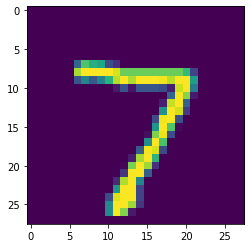

In [171]:
predictions = new_model.predict(x_test)
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])
plt.show()

### Accuracy of the base_model

In [172]:
# Creating a multiclass confusion matrix before training.
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion


array([[358,   0,   3,   1,   2,   3,   1,   0,   2,   0],
       [  0, 440,   3,   2,   0,   1,   1,   0,   3,   0],
       [  2,   3, 375,   2,   2,   7,   6,   5,  14,   2],
       [  0,   4,  11, 358,   0,  17,   0,  10,   6,   2],
       [  4,   0,   3,   0, 367,   0,   6,   3,   8,  27],
       [  7,   0,   4,  15,   7, 302,   1,   5,  25,   6],
       [ 12,   4,  10,   0,   6,  10, 334,   0,   2,   0],
       [  2,   7,   7,  15,   6,   0,   0, 355,   9,  10],
       [  5,   8,   5,   9,   4,  24,   2,   4, 318,   5],
       [  4,   0,   0,   8,  25,   5,   3,   9,  14, 323]], dtype=int64)

In [173]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 30.675703525543213 seconds ---
